## Impute Missing Values By Models

In [38]:
%matplotlib inline
import pandas as pd
import numpy as np
import xgboost as xgb
import warnings
warnings.filterwarnings('ignore')

## Load Data

In [39]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [40]:
#clean data
bad_index = train[train.life_sq > train.full_sq].index
train.ix[bad_index, "life_sq"] = np.NaN
equal_index = [601,1896,2791]
test.ix[equal_index, "life_sq"] = test.ix[equal_index, "full_sq"]
bad_index = test[test.life_sq > test.full_sq].index
test.ix[bad_index, "life_sq"] = np.NaN
bad_index = train[train.life_sq < 5].index
train.ix[bad_index, "life_sq"] = np.NaN
bad_index = test[test.life_sq < 5].index
test.ix[bad_index, "life_sq"] = np.NaN
bad_index = train[train.full_sq < 5].index
train.ix[bad_index, "full_sq"] = np.NaN
bad_index = test[test.full_sq < 5].index
test.ix[bad_index, "full_sq"] = np.NaN
kitch_is_build_year = [13117]
train.ix[kitch_is_build_year, "build_year"] = train.ix[kitch_is_build_year, "kitch_sq"]
bad_index = train[train.kitch_sq >= train.life_sq].index
train.ix[bad_index, "kitch_sq"] = np.NaN
bad_index = test[test.kitch_sq >= test.life_sq].index
test.ix[bad_index, "kitch_sq"] = np.NaN
bad_index = train[(train.kitch_sq == 0).values + (train.kitch_sq == 1).values].index
train.ix[bad_index, "kitch_sq"] = np.NaN
bad_index = test[(test.kitch_sq == 0).values + (test.kitch_sq == 1).values].index
test.ix[bad_index, "kitch_sq"] = np.NaN
bad_index = train[(train.full_sq > 210) & (train.life_sq / train.full_sq < 0.3)].index
train.ix[bad_index, "full_sq"] = np.NaN
bad_index = test[(test.full_sq > 150) & (test.life_sq / test.full_sq < 0.3)].index
test.ix[bad_index, "full_sq"] = np.NaN
bad_index = train[train.life_sq > 300].index
train.ix[bad_index, ["life_sq", "full_sq"]] = np.NaN
bad_index = test[test.life_sq > 200].index
test.ix[bad_index, ["life_sq", "full_sq"]] = np.NaN
bad_index = train[train['state']>10].index
train.ix[bad_index,'state']=np.NaN
bad_index = train[train['build_year']>3000].index
train.ix[bad_index,'build_year'] = np.NaN
bad_index = test[test['state']>10].index
test.ix[bad_index,'state']=np.NaN
bad_index = test[test['build_year']>3000].index
test.ix[bad_index,'build_year'] = np.NaN
bad_index = train[train.build_year < 1500].index
train.ix[bad_index, "build_year"] = np.NaN
bad_index = test[test.build_year < 1500].index
test.ix[bad_index, "build_year"] = np.NaN
bad_index = train[train.num_room == 0].index 
train.ix[bad_index, "num_room"] = np.NaN
bad_index = test[test.num_room == 0].index 
test.ix[bad_index, "num_room"] = np.NaN
bad_index = [10076, 11621, 17764, 19390, 24007, 26713, 29172]
train.ix[bad_index, "num_room"] = np.NaN
bad_index = [3174, 7313]
test.ix[bad_index, "num_room"] = np.NaN
bad_index = train[(train.floor == 0).values * (train.max_floor == 0).values].index
train.ix[bad_index, ["max_floor", "floor"]] = np.NaN
bad_index = train[train.floor == 0].index
train.ix[bad_index, "floor"] = np.NaN
bad_index = train[train.max_floor == 0].index
train.ix[bad_index, "max_floor"] = np.NaN
bad_index = test[test.max_floor == 0].index
test.ix[bad_index, "max_floor"] = np.NaN
bad_index = train[train.floor > train.max_floor].index
train.ix[bad_index, "max_floor"] = np.NaN
bad_index = test[test.floor > test.max_floor].index
test.ix[bad_index, "max_floor"] = np.NaN
bad_index = [23584]
train.ix[bad_index, "floor"] = np.NaN
bad_index = train[train.state == 33].index
train.ix[bad_index, "state"] = np.NaN
# brings error down a lot by removing extreme price per sqm
train.loc[train.full_sq == 0, 'full_sq'] = 50
train = train[train.price_doc/train.full_sq <= 600000]
train = train[train.price_doc/train.full_sq >= 10000]

In [42]:
num_train = len(train)
price_doc = train['price_doc']

In [5]:
train['set_marker'] = [0]*num_train
test['set_marker'] = [1]*len(test)

In [6]:
col = list(test.columns)
col.remove('timestamp')
All_data = pd.concat([train[col],test[col]])

In [7]:
cat = []
for c in All_data.columns:
    if All_data[c].dtype == 'object':
        All_data[c] = pd.factorize(All_data[c], sort=True)[0]
        cat.append(c)

In [8]:
### Additional Cat Features
add_cat = [each for each in list(All_data.columns) if 'ID' in each]
#add_cat.append('build_year')
cat = cat+add_cat

In [9]:
for dd in add_cat:
    All_data[dd] = pd.factorize(All_data[dd],sort=True)[0]

In [10]:
All_data['id'] = range(len(All_data))

## Counting Missing Values 

In [11]:
NA_Count = pd.DataFrame({'Sum of NA':All_data.isnull().sum()}).sort(['Sum of NA'],ascending=[0])
NA_Count['Percentage'] = NA_Count['Sum of NA']/All_data.shape[1]

We just try to impute missing values that have obvious impact on the price.

In [12]:
imputed_values = ['kitch_sq','build_year','state','max_floor','num_room','material','life_sq']

## CV Imputation Model

In [13]:
from sklearn.preprocessing import LabelEncoder

In [14]:
def impute_cv(col,params,type_='reg'):
    if col != 'max_floor':
        train_set = All_data[All_data[col].notnull()]
        predict_set = All_data[All_data[col].isnull()]
    else:
        train_set = All_data[All_data[col].notnull()]
        predict_set = All_data[All_data[col].isnull()&All_data['floor'].notnull()]
    if type_!='reg':
        train_set[col] = LabelEncoder().fit_transform(train_set[col])
    cols = list(train_set)[1:]
    cols.remove('set_marker')
    cols.remove(col)
    dtrain = xgb.DMatrix(train_set[cols],train_set[col])
    cv = xgb.cv(params,dtrain,num_boost_round=1000,early_stopping_rounds=20,verbose_eval=50, show_stdv=False)
    print(len(cv))

In [15]:
def impute_value(col,params,rounds,type_='reg'):
    train_set = All_data[All_data[col].notnull()]
    predict_set = All_data[All_data[col].isnull()]
    if type_!='reg':
        train_set[col] = LabelEncoder().fit_transform(train_set[col])
    cols = list(train_set)[1:]
    cols.remove('set_marker')
    cols.remove(col)
    dtrain = xgb.DMatrix(train_set[cols],train_set[col])
    model = xgb.train(params,dtrain,num_boost_round = rounds)
    dtest = xgb.DMatrix(predict_set[cols])
    predicted_value = model.predict(dtest)
    predict_set[col] = predicted_value
    return pd.concat([train_set,predict_set])

In [16]:
param_lifesq = {
    #'booster':'gblinear',
    'eta': 0.05,
    'max_depth': 5,
    'subsample': 0.7,
    'colsample_bytree': 0.7,
    'objective': 'reg:linear',
    'eval_metric': 'rmse',
    'silent': 1
}
All_data = impute_value('life_sq',param_lifesq,328)

In [17]:
param_kitchensq = {
    #'booster':'gblinear',
    'eta': 0.05,
    'max_depth': 4,
    'subsample': 0.7,
    'colsample_bytree': 0.7,
    'objective': 'reg:linear',
    'eval_metric': 'rmse',
    'silent': 1
}
All_data = impute_value('kitch_sq',param_kitchensq,470)

In [18]:
param_state = {
    #'booster':'gblinear',
    'eta': 0.05,
    'max_depth': 2,
    'subsample': 0.7,
    'colsample_bytree':0.7,
    'objective': 'multi:softmax',
    'num_class':4,
    'silent': 1
}
All_data=impute_value('state',param_state,305,'clf')

In [19]:
param_year = {
    #'booster':'gblinear',
    'eta': 0.05,
    'max_depth': 5,
    'subsample': 0.7,
    'colsample_bytree':0.7,
    'objective': 'reg:linear',
    'silent': 1
}
All_data=impute_value('build_year',param_year,709)

In [20]:
All_data['build_year'] = round(All_data['build_year'])

In [21]:
param_maxfloor = {
    #'booster':'gblinear',
    'eta': 0.05,
    'max_depth': 5,
    'subsample': 0.7,
    'colsample_bytree':0.7,
    'objective': 'reg:linear',
    'silent': 1
}
All_data= impute_value('max_floor',param_maxfloor,450)
All_data['max_floor'] = round(All_data['max_floor'])
indexs = All_data[All_data['floor'].isnull()].index
All_data.ix[indexs,'max_floor'] = np.nan

In [22]:
param_room = {
    #'booster':'gblinear',
    'eta': 0.05,
    'max_depth': 5,
    'subsample': 0.7,
    'colsample_bytree':0.7,
    'objective': 'reg:linear',
    'silent': 1
}
All_data = impute_value('num_room',param_room,600)
All_data['num_room'] = round(All_data['num_room'])

In [23]:
param_material = {
    #'booster':'gblinear',
    'eta': 0.05,
    'max_depth': 5,
    'subsample': 0.7,
    'colsample_bytree':0.7,
    'objective': 'multi:softmax',
    'num_class':6,
    'silent': 1
}
All_data = impute_value('material',param_material,250,'clf')

In [31]:
All_data = All_data.sort_values(['id'],ascending=1)

In [36]:
train_filled = All_data[All_data['set_marker']==0]
test_filled = All_data[All_data['set_marker']==1]

In [37]:
del train_filled['id']
del test_filled['id']
del train_filled['set_marker']
del test_filled['set_marker']

In [43]:
train_filled['price_doc'] = price_doc

In [46]:
train_filled.to_csv('train_filled.csv',index=False)
test_filled.to_csv('test_filled.csv',index=False)

**Extra Move: Deal with life sq that is larger than full_sq**

In [54]:
index = train_filled.query('full_sq<=life_sq').index

In [56]:
train_filled.ix[index,'life_sq'] = train_filled.ix[index,'full_sq']*0.8

In [57]:
index = test_filled.query('full_sq<=life_sq').index
test_filled.ix[index,'life_sq'] = test_filled.ix[index,'full_sq']*0.8

# Experiment: Fit XGBOOST With 0.95 Label with new dataset

In [59]:
col = list(test_filled.columns)
label = train_filled['price_doc']*0.95+10

In [60]:
dtrain = xgb.DMatrix(train_filled[col],label)
dtest = xgb.DMatrix(test_filled[col])

In [77]:
params = {
    'eta': 0.07, ## Try 0.01,3,5
    'max_depth': 3,## Try 4,5,6
    'subsample': 0.7,
    'colsample_bytree': 0.7,
    'objective': 'reg:linear',
    'eval_metric': 'rmse',
    'silent': 1
}

[0]	train-rmse:7.66605e+06	test-rmse:7.6711e+06
[50]	train-rmse:2.52233e+06	test-rmse:2.69124e+06
[100]	train-rmse:2.32054e+06	test-rmse:2.54676e+06
[150]	train-rmse:2.23476e+06	test-rmse:2.5132e+06
[200]	train-rmse:2.16777e+06	test-rmse:2.48588e+06
[250]	train-rmse:2.11143e+06	test-rmse:2.46581e+06
[300]	train-rmse:2.06559e+06	test-rmse:2.45498e+06
[350]	train-rmse:2.02667e+06	test-rmse:2.44775e+06
[400]	train-rmse:1.99332e+06	test-rmse:2.442e+06
[450]	train-rmse:1.96185e+06	test-rmse:2.43293e+06
[500]	train-rmse:1.93267e+06	test-rmse:2.42452e+06
[550]	train-rmse:1.90498e+06	test-rmse:2.41871e+06
[600]	train-rmse:1.88147e+06	test-rmse:2.41511e+06
[650]	train-rmse:1.85958e+06	test-rmse:2.41016e+06
Performance does not improve from 672 rounds


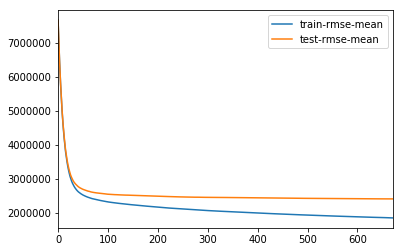

In [78]:
xgb_cvalid = xgb.cv(params, dtrain, num_boost_round=1000, early_stopping_rounds=20,
    verbose_eval=50, show_stdv=False,seed=42)
xgb_cvalid[['train-rmse-mean', 'test-rmse-mean']].plot()

print('Performance does not improve from '+str(len(xgb_cvalid))+' rounds')

In [ ]:
depth 4
[0]	train-rmse:7.78794e+06	test-rmse:7.79231e+06
[50]	train-rmse:2.50129e+06	test-rmse:2.72129e+06
[100]	train-rmse:2.21127e+06	test-rmse:2.51832e+06
[150]	train-rmse:2.11924e+06	test-rmse:2.4796e+06
[200]	train-rmse:2.04932e+06	test-rmse:2.45305e+06
[250]	train-rmse:1.99495e+06	test-rmse:2.43957e+06
[300]	train-rmse:1.94462e+06	test-rmse:2.42923e+06
[350]	train-rmse:1.90324e+06	test-rmse:2.4223e+06
[400]	train-rmse:1.86579e+06	test-rmse:2.41756e+06
[450]	train-rmse:1.82896e+06	test-rmse:2.41196e+06
[500]	train-rmse:1.79516e+06	test-rmse:2.40551e+06
[550]	train-rmse:1.76368e+06	test-rmse:2.40229e+06
[600]	train-rmse:1.73457e+06	test-rmse:2.4003e+06
[650]	train-rmse:1.70934e+06	test-rmse:2.39834e+06
[700]	train-rmse:1.68411e+06	test-rmse:2.3966e+06
[750]	train-rmse:1.66048e+06	test-rmse:2.39496e+06
[800]	train-rmse:1.63862e+06	test-rmse:2.39363e+06
[850]	train-rmse:1.61562e+06	test-rmse:2.39281e+06
[900]	train-rmse:1.59478e+06	test-rmse:2.39138e+06
Performance does not improve from 907 rounds
depth 5 colsample 0.5
[0]	train-rmse:7.78284e+06	test-rmse:7.78669e+06
[50]	train-rmse:2.37051e+06	test-rmse:2.68688e+06
[100]	train-rmse:2.06046e+06	test-rmse:2.50315e+06
[150]	train-rmse:1.95511e+06	test-rmse:2.46631e+06
[200]	train-rmse:1.87565e+06	test-rmse:2.44376e+06
[250]	train-rmse:1.81136e+06	test-rmse:2.43215e+06
[300]	train-rmse:1.75556e+06	test-rmse:2.42479e+06
[350]	train-rmse:1.70175e+06	test-rmse:2.41688e+06
[400]	train-rmse:1.65626e+06	test-rmse:2.41305e+06
[450]	train-rmse:1.61382e+06	test-rmse:2.41056e+06
[500]	train-rmse:1.57572e+06	test-rmse:2.40891e+06
[550]	train-rmse:1.53905e+06	test-rmse:2.40891e+06
Performance does not improve from 542 rounds

depth 6
[0]	train-rmse:7.77669e+06	test-rmse:7.78435e+06
[50]	train-rmse:2.18274e+06	test-rmse:2.63951e+06
[100]	train-rmse:1.86747e+06	test-rmse:2.47467e+06
[150]	train-rmse:1.75422e+06	test-rmse:2.44494e+06
[200]	train-rmse:1.66756e+06	test-rmse:2.43103e+06
[250]	train-rmse:1.59503e+06	test-rmse:2.42332e+06
[300]	train-rmse:1.52951e+06	test-rmse:2.4195e+06
Performance does not improve from 322 rounds

depth 5
[0]	train-rmse:7.78141e+06	test-rmse:7.78765e+06
[50]	train-rmse:2.33646e+06	test-rmse:2.67022e+06
[100]	train-rmse:2.04217e+06	test-rmse:2.49268e+06
[150]	train-rmse:1.93966e+06	test-rmse:2.45639e+06
[200]	train-rmse:1.85933e+06	test-rmse:2.43493e+06
[250]	train-rmse:1.79328e+06	test-rmse:2.4214e+06
[300]	train-rmse:1.73983e+06	test-rmse:2.41515e+06
[350]	train-rmse:1.68843e+06	test-rmse:2.41061e+06
[400]	train-rmse:1.64079e+06	test-rmse:2.40763e+06
[450]	train-rmse:1.60132e+06	test-rmse:2.40427e+06
Performance does not improve from 439 rounds

In [63]:
model = xgb.train(params,dtrain,num_boost_round=len(xgb_cvalid))

In [64]:
def get_feature_importance(model):
    Importance = model.get_fscore()
    Importance = list(Importance.items())
    Feature= []
    Score = []
    for each in Importance:
        Feature.append(each[0])
        Score.append(each[1])
    df = pd.DataFrame({'Feature':Feature,'Score':Score}).sort_values(by=['Score'],ascending=[0])
    return df    

In [65]:
get_feature_importance(model)

,Feature,Score
179,full_sq,1309
64,life_sq,499
132,build_year,415
58,floor,411
87,kitch_sq,344
55,max_floor,337
149,state,165
12,num_room,125
13,green_zone_km,121
109,kindergarten_km,120


In [66]:
pred = model.predict(dtest)

In [68]:
sub = pd.DataFrame({'id':test['id'],'price_doc':pred})

In [69]:
sub.to_csv('NA_FilledByXGB.csv',index=False)